[[[  0   0   0]]

 [[120 120  70]]

 [[  8 255  51]]

 [[255   6  51]]

 [[ 11 102 255]]]


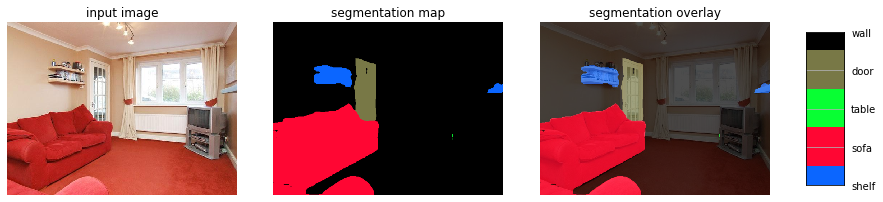

In [2]:
import requests
import json
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.image as mpimg

#URL = 'http://143.248.94.189:35005/api/predict'
#URL = 'http://143.248.96.81:35005/api/predict'
URL = 'http://143.248.96.69:35005/api/predictIndex'
#URLGetColor = 'http://143.248.96.69:35005/api/colorMap'

def convertTuple(list): 
    return tuple(i for i in list) 

def create_ade20k_label_colormap():
      return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ], dtype=np.uint8)

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_ade20k_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')
    return colormap[label]

def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    im2 = Image.fromarray(seg_image, 'RGB')
    seg_image = im2.resize(image.size, Image.BILINEAR)

    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    print(FULL_COLOR_MAP[unique_labels])
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()
    

if __name__ == "__main__":
    LABEL_NAMES = np.array(['wall' ,'building' ,'sky' ,'floor' ,'tree' ,'ceiling' ,'road' ,'bed' ,'windowpane' ,'grass' ,'cabinet' ,'sidewalk' ,'person' ,'earth' ,'door' ,'table' ,'mountain' ,'plant' ,'curtain' ,'chair' ,'car' ,'water' ,'painting' ,'sofa' ,'shelf' ,'house' ,'sea' ,'mirror' ,'rug' ,'field' ,'armchair' ,'seat' ,'fence' ,'desk' ,'rock' ,'wardrobe' ,'lamp' ,'bathtub' ,'railing' ,'cushion' ,'base' ,'box' ,'column' ,'signboard' ,'chest of drawers' ,'counter' ,'sand' ,'sink' ,'skyscraper' ,'fireplace' ,'refrigerator' ,'grandstand' ,'path' ,'stairs' ,'runway' ,'case' ,'pool table' ,'pillow' ,'screen door' ,'stairway' ,'river' ,'bridge' ,'bookcase' ,'blind' ,'coffee table' ,'toilet' ,'flower' ,'book' ,'hill' ,'bench' ,'countertop' ,'stove' ,'palm' ,'kitchen island' ,'computer' ,'swivel chair' ,'boat' ,'bar' ,'arcade machine' ,'hovel' ,'bus' ,'towel' ,'light' ,'truck' ,'tower' ,'chandelier' ,'awning' ,'streetlight' ,'booth' ,'television' ,'airplane' ,'dirt track' ,'apparel' ,'pole' ,'land' ,'bannister' ,'escalator' ,'ottoman' ,'bottle' ,'buffet' ,'poster' ,'stage' ,'van' ,'ship' ,'fountain' ,'conveyer belt' ,'canopy' ,'washer' ,'plaything' ,'swimming pool' ,'stool' ,'barrel' ,'basket' ,'waterfall' ,'tent' ,'bag' ,'minibike' ,'cradle' ,'oven' ,'ball' ,'food' ,'step' ,'tank' ,'trade name' ,'microwave' ,'pot' ,'animal' ,'bicycle' ,'lake' ,'dishwasher' ,'screen' ,'blanket' ,'sculpture' ,'hood' ,'sconce' ,'vase' ,'traffic light' ,'tray' ,'ashcan' ,'fan' ,'pier' ,'crt screen' ,'plate' ,'monitor' ,'bulletin board' ,'shower' ,'radiator' ,'glass' ,'clock' ,'flag'])
    FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
    FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
    
    img_path = '../../Dataset/ex1.jpg'
    im1 = cv2.imread(img_path)
    #img_gt = '../../Dataset/groundtruth1.png'

    img = Image.open(img_path)  
    img = img.convert("RGB")

    rNum, cNum = im1.shape[:2]
    #widthNum, heightNum = img.size

    im1=cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)
    
    strImgTest = '['
    for r in range(rNum):
        strImgTest+='['
        for c in range(cNum):
            strTmp = '['+str((im1[r][c][0]))+','+str((im1[r][c][1]))+','+str((im1[r][c][2]))+']'
            strImgTest+=strTmp

            if c !=cNum-1 :
                strImgTest+=','
        strImgTest+=']'
        if r != rNum-1:
            strImgTest += ','
    strImgTest+=']'

    res = requests.post(url=URL, data={'image':strImgTest})
    #print(res.text)
    param = json.loads(res.text)
    #with open('jsonResult.txt', 'w') as json_file:
    #    json.dump(param, json_file)

    seg_res = param['seg_index']
    seg_map = np.array(seg_res, dtype=np.uint8)
    
    for row in range(len(seg_map)):
        for col in range(len(seg_map[0])):
            seg_map[row, col] -= 1
            x = seg_map[row, col]
            if(LABEL_NAMES[x] != 'door' and LABEL_NAMES[x] != 'table' and LABEL_NAMES[x] != 'shelf' and LABEL_NAMES[x] != 'sofa'):
                seg_map[row, col] = 0
    
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    
    #im2 =  Image.fromarray(seg_image, 'RGB')
    #im2 = im2.resize((rNum, cNum), Image.BILINEAR)
    vis_segmentation(img, seg_map)

    #plt.figure(figsize=(20, 15))
    #plt.imshow(seg_image)
    
    
